In [1]:
import os
import sys
import matplotlib.pyplot as plt

os.chdir('..')

import numpy as np
import torch
import pandas as pd
import random

from models.TrainPlanningOperator3D import PlanningOperator3D

from planners import generaterandompos
from planners import AStarPlanner, FMMPlanner, PlanningOperatorPlanner, testplanneronmaps, plot_2d_map_and_two_paths



Load Gibson Environment

In [2]:
Ntotal = 50

ntest = 5
ntrain = 45

sub = 1
Sx = 84
Sy = 84
Sz = 84

maps = np.load('dataset/occupancy_maps.npy')
# maps = maps[:Ntotal][-ntest:, ::sub, ::sub, ::sub][:, :Sx, :Sy, :Sz]
maps = maps[:Ntotal][:ntrain, ::sub, ::sub, ::sub][:, :Sx, :Sy, :Sz]
# maps = maps[0:8,:,:,:]
# maps = np.repeat(maps, repeats=5, axis=0)



Load Model

In [3]:


# Model
modes = 12
width = 32
nlayers = 1

model = PlanningOperator3D(modes, modes, modes, width, nlayers)
model.load_state_dict(torch.load("/mountvol/igibchunk-dataset-84-10g/planningoperator_env84_m12_w32_l1_b10_lr3e-3_10g_23sep/n450_lr3.000000e-03_gamma6.000000e-01_wd3.000000e-06_seed5/model3d.ckpt"))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


/tmp/ipykernel_16804/19159190.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/mountvol/igibchunk-dataset-84-10g/planningoperator_env84

PlanningOperator3D(
  (fc0): Linear(in_features=3, out_features=32, bias=True)
  (conv0): SpectralConv3d()
  (w0): Conv3d(32, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (fc1): DeepNormMetric(
    (Us): ModuleList(
      (0-1): 2 x Linear(in_features=32, out_features=128, bias=False)
    )
    (Ws): ModuleList(
      (0): ConstrainedLinear(in_features=128, out_features=128, bias=False)
    )
    (activation): MaxReLUPairwiseActivation(
      (avg_pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
    (output_activation): ConcaveActivation()
    (reduce_metric): ReduceMetric()
  )
)

Start [10 58 60]
Goal [10 43 46]

AStar
Success: True 
PathCost: 20.798989873223338 
PlanningTime: 0.006134748458862305

FMM
Success: True 
PathCost: 20.798989873223338 
PlanningTime: 0.22176361083984375

Planning Operator
Success: True 
PathCost: 22.706013344398027 
Total Time 0.5785789489746094


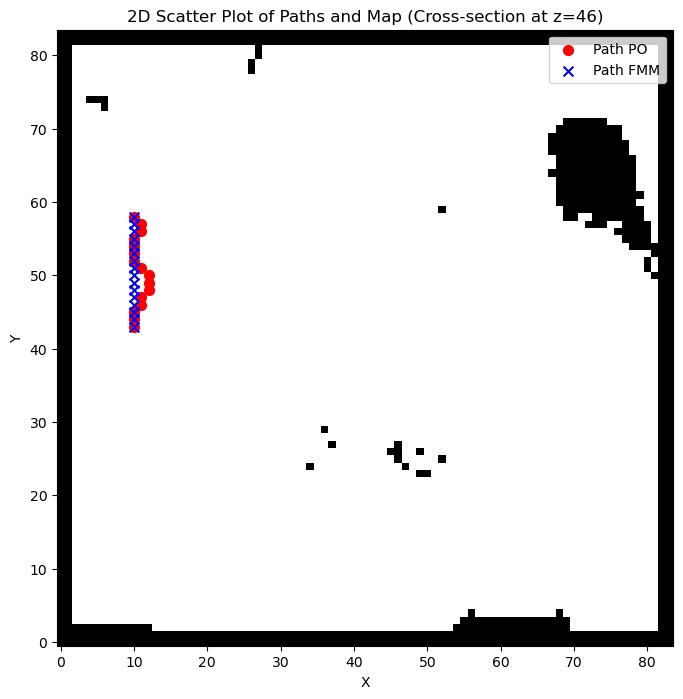

In [4]:
startpositions = generaterandompos(maps)
goalpositions = generaterandompos(maps)
index =  np.random.randint(0, maps.shape[0])  
mapx = maps[index,:,:,:]
startx = startpositions[index,:]
print("Start",startx)
goalx = goalpositions[index,:]
# goalx[2] = startx[2]
print("Goal",goalx)


success,pathcost,planningtime, path = AStarPlanner(startx, goalx, mapx)

print("\nAStar\nSuccess:", success,
      "\nPathCost:", pathcost,
      "\nPlanningTime:",planningtime)


success,pathcost,planningtime, path_1 = FMMPlanner(startx, goalx, mapx)
print("\nFMM\nSuccess:", success,
      "\nPathCost:", pathcost,
      "\nPlanningTime:",planningtime)


success,pathcost,tot_time, path_2 = PlanningOperatorPlanner(startx, goalx, mapx, model)
print("\nPlanning Operator\nSuccess:", success,
      "\nPathCost:", pathcost,
      "\nTotal Time", tot_time)


plot_2d_map_and_two_paths(path_2,path_1,mapx,z_index=goalx[2])


Generate Random Positions

In [5]:
maps = np.repeat(maps, repeats=5, axis=0)
startpositions = generaterandompos(maps)
# print(startpositions)
goalpositions = generaterandompos(maps)
# goalpositions[0][2] = startpositions[0][2]
# print(goalpositions)

In [6]:
_,_,_,successful_map_indices = testplanneronmaps(startpositions,goalpositions,maps,PlanningOperatorPlanner,printvalues=True, model=model)
compmaps = maps[successful_map_indices,:,:,:]
compstartpositions = startpositions[successful_map_indices,:] 
compgoalpositions = goalpositions[successful_map_indices,:]

225it [01:10,  3.20it/s]

Average Path Cost: 69.76979685155418 
Average Planning Time: 0.29165630135239595 
Average Success Rate: 0.9288888888888889


In [7]:
testplanneronmaps(compstartpositions,compgoalpositions,compmaps,AStarPlanner,printvalues=True)

209it [02:28,  1.40it/s]

Average Path Cost: 45.178107648638 
Average Planning Time: 0.7119370430850527 
Average Success Rate: 1.0


(45.178107648638,
 0.7119370430850527,
 1.0,
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
 

In [8]:
testplanneronmaps(compstartpositions,compgoalpositions,compmaps,FMMPlanner,printvalues=True)

209it [00:33,  6.31it/s]

Average Path Cost: 46.14170143447709 
Average Planning Time: 0.15783146351718447 
Average Success Rate: 1.0


(46.14170143447709,
 0.15783146351718447,
 1.0,
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151